In [244]:
%matplotlib inline
import matplotlib_inline   # setup output image format
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')
import matplotlib.pyplot as plt
import matplotlib
from numpy import *
from sklearn import *
from scipy import stats
random.seed(100)
import csv
from scipy import io
import pickle
from IPython.display import Audio, display
import os.path
import numpy as np
import pandas as pd

In [342]:
def showAudio(info):
    myfile = 'musicmp3/' + info['fname'] + '.mp3'
    if os.path.exists(myfile):
        display(Audio(myfile))
    else:
        print("*** mp3 file " + myfile + " could not be found ***")

def load_pickle(fname):
    f = open(fname, 'rb')
    out = pickle.load(f)
    f.close()
    return out

# Load the Data
The training and test data are stored in various pickle files. Here we assume the data is stored in the `musicdata` directory. The below code will load the data, including tags and extracted features.

In [343]:
def data_split(data, data_indices, val_fold_idx, k_fold, prefix='mfcc'):
    assert prefix in ['mfcc', 'mel', 'chroma']
    val_indices = data_indices[val_fold_idx*len(data_indices)//k_fold: (val_fold_idx+1)*len(data_indices)//k_fold]  # 分为k_fold份，第val_fold_idx子份作为验证集
    train_indices = [idx for idx in data_indices if idx not in val_indices]  # 其余作为训练集
    train_labels = [data['primary_label'][i] for i in train_indices]

    val_labels = [data['primary_label'][i] for i in val_indices]
    missing_labels = list(set(val_labels)-set(train_labels)) # labels in val set but not in train set
    # val_indices_copy = val_indices.copy()
    for i, val_idx in enumerate(val_indices):
        if data['primary_label'][val_idx] in missing_labels:  # if a sample's label is in val set but not in train set
            train_indices.append(val_indices.pop(i))  # then we shift it from val set to train set

    # fetch the data
    train_inps = [data[prefix][i] for i in train_indices]
    train_tags = [data['primary_label_idx'][i] for i in train_indices]
    train_tag_names = [data['primary_label'][i] for i in train_indices]


    test_inps = [data[prefix][i] for i in val_indices]
    test_tags = [data['primary_label_idx'][i] for i in val_indices]
    test_tag_names = [data['primary_label'][i] for i in val_indices]


    return train_inps, train_tags, train_tag_names, test_inps, test_tags, test_tag_names


In [344]:
def idx_2_onehot(tag_list):
    new_tag_list = np.zeros((len(tag_list), 264))
    for index, each_tag in enumerate(tag_list): 
        new_tag_list[index][each_tag] = 1
    return new_tag_list

In [345]:
data = load_pickle('train_mfcc(n=20).pickle3')
data_indices = list(range(len(data['primary_label'])))
random.seed(42)  # do not change this otherwise the split will be different
random.shuffle(data_indices)  # a shuffled list containing data indices (for data split)
val_fold_idx =0
k_fold=5
prefix='mfcc'

train_mfccs, train_mfcc_tags, train_tag_names, test_mfccs, test_mfcc_tags, test_tag_names = data_split(data, data_indices, val_fold_idx, k_fold, prefix )

# input data transpose from [20, x] --> [x, 20]
train_mfccs = [i.T for i in train_mfccs]
test_mfccs = [i.T for i in test_mfccs]

# generate one-hot class
train_mfcc_tags = idx_2_onehot(train_mfcc_tags)
test_mfcc_tags = idx_2_onehot(test_mfcc_tags)

In [346]:
train_tag_names = [i.split(',') for i in train_tag_names]
train_tag_names, _ = unique(concatenate(train_tag_names), return_counts=True)


test_tag_names = [i.split(',') for i in test_tag_names]
test_tag_names, _ = unique(concatenate(test_tag_names), return_counts=True)


## Data Pre-processing - Delta MFCCs

The first thing you might notice is that the MFCC vectors are time-series.  One trick to include time-series information into a vector representation is to append the difference between two consecutive feature vectors.  This way, we can include some relationship between two time steps in the representation.

In [347]:
# compute delta MFCCs
def compute_delta_mfccs(mfccs):
    dmfccs = []
    for m in mfccs:
        tmp = m[1:] - m[0:-1]
        dm = hstack((m[0:-1], tmp))
        dmfccs.append(dm)
    return dmfccs

In [348]:
train_dmfccs = compute_delta_mfccs(train_mfccs)
test_dmfccs  = compute_delta_mfccs(test_mfccs)

In [349]:
# put dmfccs from all training data together
all_dmfccs = vstack(train_dmfccs)

In [350]:
# run k-means to build codebook
km = cluster.KMeans(n_clusters=100, random_state=4487)
km.fit(all_dmfccs[0::100])  # subsample by 10 to make it faster
km.cluster_centers_

array([[-3.92244263e+02,  9.31140594e+01,  1.04383965e+01, ...,
        -3.64257284e-02, -1.39405923e-02,  1.22524966e-02],
       [-4.38240692e+02,  8.27504883e+01, -6.34328880e+01, ...,
        -1.16185904e-01,  2.86221579e-02, -1.38637498e-01],
       [-1.69863007e+02,  7.46409607e+01,  7.67882538e+00, ...,
        -2.50646770e-02, -1.12834666e-03, -1.02642089e-01],
       ...,
       [-6.08091309e+02,  2.71865807e+01,  5.59591293e+00, ...,
         7.65674189e-02, -5.11297546e-02, -8.38358700e-02],
       [-6.06609558e+02, -6.21723976e+01, -1.04065552e+02, ...,
        -1.64237544e-01, -5.43742329e-02, -5.54775633e-02],
       [-2.16367752e+02,  6.41793213e+01, -2.42670174e+01, ...,
         1.02581745e-02,  2.19104346e-02,  8.91144127e-02]], dtype=float32)

Now transform the data into BOW.

In [354]:
def bow_transform(model, mfccs):
    numwords = model.cluster_centers_.shape[0]
    bows = zeros((len(mfccs), numwords))
    for i in range(len(mfccs)):
        w = model.predict(mfccs[i])
        bw = bincount(w, minlength=numwords)
        bows[i,:] = bw
    return bows

In [355]:
train_bow = bow_transform(km, train_dmfccs)
test_bow  = bow_transform(km, test_dmfccs)

In [356]:
train_classes, test_classes = train_mfcc_tags, test_mfcc_tags

In [357]:
# double check we did this correctly...
# it should be the same as the tag counts above
# make sure that each class has at least one sample!!!!, This is extremely essential
print(sum(train_classes,axis=0))


[ 11. 100.  24.  12.  26.  74.  36.   5.  51.  30.  88.   1.  67.  51.
  19.  23.  38.  35.  11.  22. 408.  38.   6.  60.  26.  85.  20.  45.
  63. 222.  37. 130.  17.  31.  21.  14.  11.  21.  13.   9.   6.  17.
  12.  10.   2.  48.   2.  22.  20.  30.  22.   7.   1.  69.  33.  19.
  51.   7.  28.  24. 123.  34. 135.  11.   4.   7.  63.  22.  27.  85.
 336. 142. 242. 379. 400.   1.  29.  42.  29.   7.  66.   3.   8.  13.
 388.  17. 120.   4.  50. 353.  19.   5.  13. 104.  32. 112.  33. 199.
  10.  57.   2.   5.   1.  64.  11. 110. 200.  79.  13.  21.  19.  10.
  41.  58.  40.  20.  39.   9.  99.  26.  16.  46.   6. 350.  13.   4.
   7.  23.  41.   7.  82.  53.  12.  32.  24. 294.  55.  12.  11.   1.
   2.  15.  13.   2.  12.   4.  35.   6.  26.  32.  25.  18.  11.  15.
  17.  16.  13.  19.   6.   9.   3.  73. 103.  40.   6.  11.  36. 138.
  13. 222.  37.  21.  18.  44.  96.  61.  10.  37.  43.   8.   2.   5.
  19. 186.  22.  91.  22.   9.  30.   6.   6.  64.  24.  19.   3.  37.
  52. 

## Baseline experiments

Next, we will run a baseline experiment doing semantic tagging with bag-of-audio words.

Apply TF-IDF to the count vectors.

In [358]:
# convert to TF
tf_trans = feature_extraction.text.TfidfTransformer(use_idf=True, norm='l1')
train_Xtf = tf_trans.fit_transform(train_bow)
test_Xtf  = tf_trans.transform(test_bow)

Now learn a logisic regression classifier for each tag.

In [359]:
import warnings
warnings.filterwarnings('ignore')

tagmodels = {}

for i,t in enumerate(train_tag_names):
    print('training {} - {}'.format(i, t))
    myY = train_classes[:,i].ravel()
    lr = linear_model.LogisticRegressionCV(Cs=1, cv=2,  class_weight='balanced', solver='saga', n_jobs=8)
    lr.fit(train_Xtf, myY)
    tagmodels[t] = lr

training 0 - abethr1
training 1 - abhori1
training 2 - abythr1
training 3 - afbfly1
training 4 - afdfly1
training 5 - afecuc1
training 6 - affeag1
training 7 - afgfly1


KeyboardInterrupt: 

To see how we did on tagging the training set, we compute the tag scores.

In [231]:
train_predscore = zeros(shape=(len(train_mfccs), len(train_tag_names)))

for i,t in enumerate(train_tag_names):
    tmp = tagmodels[t].decision_function(train_Xtf)
    train_predscore[:,i] = tmp

And then plot the ROC curve using the training classes and training predicted scores.

In [360]:
# plot an ROC curve using class labels and class scores
import numpy as np

def plot_roc(tagnames, Yclasses, Yscores):
    fprall = []
    tprall = []
    aucall = []

    missing_count = 0
    for i in range(len(tagnames)):
        if Yclasses[:, i].sum() == 0:
            missing_count = missing_count+1
            continue
        fpr, tpr, thresholds = metrics.roc_curve(Yclasses[:,i], Yscores[:,i])

        plt.plot(fpr, tpr, lw=0.5, alpha=0.5)
        auc = metrics.auc(fpr, tpr)

        tprall.append(tpr)        
        fprall.append(fpr)
        aucall.append(auc)

    # Then interpolate all ROC curves at this points
    all_fpr = unique(concatenate(fprall))
    mean_tpr = zeros_like(all_fpr)
    
    for i in range(len(tagnames)-missing_count):
        mean_tpr += interp(all_fpr, fprall[i], tprall[i])

    # Finally average it and compute AUC
    mean_tpr /= len(tagnames)

    # auc of the average ROC curve
    auc = metrics.auc(all_fpr, mean_tpr)

    # average AUC
    mc_auc = mean(aucall)

    plt.plot(all_fpr, mean_tpr, 'k-', lw=2)
    plt.title('MCAUC={:.4f}, AUC={:.4f}'.format(mc_auc, auc))
    plt.xlabel('FPR')
    plt.ylabel('TPR')

    plt.grid(True)

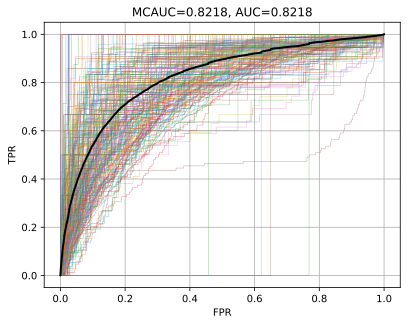

In [262]:
plot_roc(train_tag_names, train_classes, train_predscore)

Note that AUC is the AUC of the black curve, while MCAUC is the average of the AUCs for all the color curves.

Now apply the LR classifiers to the test set to predict the score for each tag.

In [263]:
test_predscore = zeros(shape=(len(test_mfccs), len(train_tag_names)))

for i,t in enumerate(train_tag_names):
    tmp = tagmodels[t].decision_function(test_Xtf)
    test_predscore[:,i] = tmp

(239,) (3386, 264) (3386, 264)


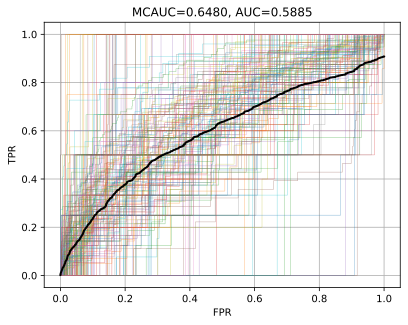

In [264]:
plot_roc(test_tag_names, test_classes, test_predscore)

In [338]:
print('The LRAP of logistic regression is: ', metrics.label_ranking_average_precision_score(test_classes, test_predscore))

The LRAP of logistic regression is:  0.010538403687873127


## YOUR CODE and DOCUMENTATION HERE

### Different Feature Representations

### Different Dimensionality Reduction Methods

In [290]:
trainX, trainY = train_bow, train_classes
testX, testY = test_bow, test_classes

# convert to TF
tf_trans = feature_extraction.text.TfidfTransformer(use_idf=True, norm='l1')
train_Xtf = tf_trans.fit_transform(trainX)
test_Xtf  = tf_trans.transform(testX)



(3386, 264)
(13555, 100) (3386, 100) 239 (3386, 264)


In [361]:
def evaluate_tagmodels(tagmodels, test_x=test_Xtf):
    # test set
    test_predscore = zeros(shape=testY.shape)
    for i,t in enumerate(test_tag_names):
        tmp = tagmodels[t].decision_function(test_x)
        test_predscore[:,i] = tmp
    LRAP = metrics.label_ranking_average_precision_score(testY, test_predscore)
    
    print(f'The LRAP of test is : {LRAP}')

In [292]:
import warnings
warnings.filterwarnings('ignore')

print('----- Logistic Regression ------')
tagmodels = {}
for i,t in enumerate(tagnames):
    # print('training {} - {}'.format(i, t))
    myY = trainY[:,i].ravel()
    lr = linear_model.LogisticRegressionCV(Cs=logspace(-4,4,10), cv=5, class_weight='balanced', solver='saga', n_jobs=8)
    lr.fit(train_Xtf, myY)
    tagmodels[t] = lr

In [293]:
# evaluation for logistic regression

evaluate_tagmodels(tagmodels, train_Xtf, test_Xtf)

The LRAP of test is : 0.021608388109111032


In [306]:
print('\n----- Logistic Regression with PCA ------')

pca = decomposition.PCA(n_components=20) 
WtrainX  = pca.fit_transform(trainX)  
WtestX = pca.transform(testX)  
print(WtrainX.shape, WtestX.shape)

tagmodels = {}
for i,t in enumerate(tagnames):
    # print('training {} - {}'.format(i, t))
    myY = trainY[:,i].ravel()
    lr = linear_model.LogisticRegressionCV(Cs=logspace(-4,4,10), cv=5, class_weight='balanced', solver='saga', max_iter=2000, n_jobs=8)
    lr.fit(WtrainX, myY)
    tagmodels[t] = lr



----- Logistic Regression with PCA ------
(13555, 20) (3386, 20)


In [309]:
# evaluation for logistic regression (with PCA)
evaluate_tagmodels(tagmodels, WtrainX, WtestX)

The LRAP of test is : 0.017044493262997364


In [307]:
print('\n------- Linear Dimensionality Reduction - NMF ----------')

nmf = decomposition.NMF(n_components=20)
WtrainX_nmf  = nmf.fit_transform(trainX)  
WtestX_nmf = nmf.transform(testX)  

tagmodels = {}
for i,t in enumerate(tagnames):
    # print('training {} - {}'.format(i, t))
    myY = trainY[:,i].ravel()
    lr = linear_model.LogisticRegressionCV(Cs=logspace(-4,4,10), cv=5, class_weight='balanced', solver='saga', max_iter=2000, n_jobs=8)
    lr.fit(WtrainX_nmf, myY)
    tagmodels[t] = lr



------- Linear Dimensionality Reduction - NMF ----------


In [310]:
# evaluation (Linear Dimensionality Reduction - NMF)
evaluate_tagmodels(tagmodels, WtrainX_nmf, WtestX_nmf)

The LRAP of test is : 0.01852515536587298


In [294]:
print('------- Non-Linear Dimensionality Reduction - KPCA ----------')

kpca = decomposition.KernelPCA(n_components=20, kernel='rbf', gamma=0.001, n_jobs=-1)
WtrainX_kpca  = kpca.fit_transform(trainX)  
WtestX_kpca = kpca.transform(testX)  

tagmodels = {}
for i,t in enumerate(tagnames):
    # print('training {} - {}'.format(i, t))
    myY = trainY[:,i].ravel()
    lr = linear_model.LogisticRegressionCV(Cs=logspace(-4,4,10), cv=5, class_weight='balanced', solver='saga', max_iter=2000, n_jobs=8)
    lr.fit(WtrainX_kpca, myY)
    tagmodels[t] = lr


------- Non-Linear Dimensionality Reduction - KPCA ----------


In [314]:
# evaluation (KPCA)
evaluate_tagmodels(tagmodels, WtestX_kpca)

(3386, 264) (3386, 264)
The LRAP of test is : 0.01498271004739197


### Different Image Classifiers

In [353]:
print('----- Linear SVM ------')
tagmodels = {}
for i,t in enumerate(tagnames):
    # print('training {} - {}'.format(i, t))
    myY = trainY[:,i].ravel()
    lr = svm.SVC(kernel='linear')
    lr.fit(train_Xtf, myY)
    tagmodels[t] = lr

----- Linear SVM ------


In [362]:
evaluate_tagmodels(tagmodels)

KeyError: 'afgfly1'

In [339]:
print('----- SVM with Linear kernel (Grid Search) ------')
C_tmp = logspace(-2, 3, 10)

tagmodels = {}
for i,t in enumerate(tagnames):
    # print('training {} - {}'.format(i, t))
    myY = trainY[:,i].ravel()
    model_linear = svm.SVC(kernel='linear')
    model_linear = model_selection.GridSearchCV(estimator=model_linear, param_grid={'C': C_tmp}, cv=5, n_jobs=8)

    model_linear.fit(train_Xtf, myY)
    tagmodels[t] = model_linear

----- SVM with Linear kernel (Grid Search) ------


KeyboardInterrupt: 

In [340]:
evaluate_tagmodels(tagmodels)

KeyError: 'cibwar1'

In [299]:
print('----- SVM with RBF kernel ------')
tagmodels = {}
for i,t in enumerate(tagnames):
    # print('training {} - {}'.format(i, t))
    myY = trainY[:,i].ravel()
    lr = svm.SVC(kernel='rbf')
    lr.fit(train_Xtf, myY)
    tagmodels[t] = lr


----- SVM with RBF kernel ------


In [300]:

evaluate_tagmodels(tagmodels)

The LRAP of test is : 0.013546659364806306


In [301]:
print('----- SVM with RBF kernel (Grid Search) ------')
C_tmp = logspace(-2, 3, 10)

tagmodels = {}
for i,t in enumerate(tagnames):
    # print('training {} - {}'.format(i, t))
    myY = trainY[:,i].ravel()
    model_svm = svm.SVC(kernel='rbf')
    lr = model_selection.GridSearchCV(estimator=model_svm, param_grid={'C': C_tmp}, cv=5, n_jobs=8)
    lr.fit(train_Xtf, myY)
    # print(lr.best_params_)
    tagmodels[t] = lr


----- SVM with RBF kernel (Grid Search) ------


In [302]:
evaluate_tagmodels(tagmodels)

The LRAP of test is : 0.013622749082841822


In [303]:
print('-----  AdaBoost (Grid Search) ------')
parameters = {'n_estimators': [50, 100, 150], 'learning_rate': [0.1, 1, 10]}

tagmodels = {}
for i,t in enumerate(tagnames):
    # print('training {} - {}'.format(i, t))
    myY = trainY[:,i].ravel()
    adaclf = ensemble.AdaBoostClassifier(random_state=4487)
    lr = model_selection.GridSearchCV(adaclf, parameters, cv=5, n_jobs=8)
    lr.fit(train_Xtf, myY)
    tagmodels[t] = lr

-----  AdaBoost (Grid Search) ------


In [335]:
evaluate_tagmodels(tagmodels)

The LRAP of test is : 0.1926572673255123617


In [305]:
print('-----  XGBClassifier ------')
!pip install xgboost
import xgboost as xgb  

parameters = {
    'max_depth': [3, 5, 7, 10, 20, 30],
    'learning_rate': [0.01, 0.1, 0.2, 1, 10],
    'n_estimators': [50, 100, 150, 200, 300]
}

xgbclf = xgb.XGBClassifier()
xgbclf = model_selection.GridSearchCV(xgbclf, parameters, cv=5, n_jobs=8)
xgbclf.fit(train_Xtf, myY)


-----  XGBClassifier ------


GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
                                     max_cat_threshold=None,
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, predictor=None,
                                     random_state=None, ...),
             n_jobs=8,
             param_grid={'learning_rate': [0.01, 0.1, 0.2, 1, 10],
                         'max_depth': [3, 5, 7, 10, 20, 30],
                         'n_estimators': [50, 100, 150, 200, 300]})

In [332]:
y_pred_xgbclf = xgbclf.predict_proba(test_Xtf)
y_pred_xgbclf = np.argmax(y_pred_xgbclf, axis=1)
onehot_preds = np.zeros_like(testY)
onehot_preds[np.arange(testY.shape[0]), y_pred_xgbclf] = 1
LRAP = metrics.label_ranking_average_precision_score(testY, onehot_preds)

print(f'The LRAP of test is : {LRAP}') 


The LRAP of test is : 0.2496473894288434516
